# Convolutional neural networks in using *Tensorflow*

A *convolutional neural network (CNN)* is a network that contains *convolution layers*. The meaning of *convolution* is discussed below.

In this notebook we will user Tensorflow to create a *CNN* to classify digits from tensorflow's version of the MNIST. 

First we load the data which is already separated into training and testing sets.
### Load the data

In [ ]:
from tensorflow.keras.datasets import mnist
(X_train, y_train), (X_test, y_test) = mnist.load_data()

### Visualize the data

In [ ]:
import matplotlib.pyplot as plt
figure, axes = plt.subplots(3,10, figsize = (15,6))

for ax,image,number in zip(axes.ravel(), X_train, y_train) :
    ax.axis('off')
    ax.imshow(image, cmap = plt.cm.gray_r)
    ax.set_title('Number: ' + str(number))

Let's look at the 3rd training image, which is the number 4

In [ ]:
x4 = X_train[2]
plt.axis('off')
plt.imshow(x4,cmap = plt.cm.gray_r)
None

## Convolutions

The process of *convolution* involves using matrix multiplication to multiply a small region of an image (typically a 3x3 region) by a *filter* matrix (also called a *kernel*) to yield a single value. In the image below, the *filter* is applied to the top corner of the image and yields the value -3.

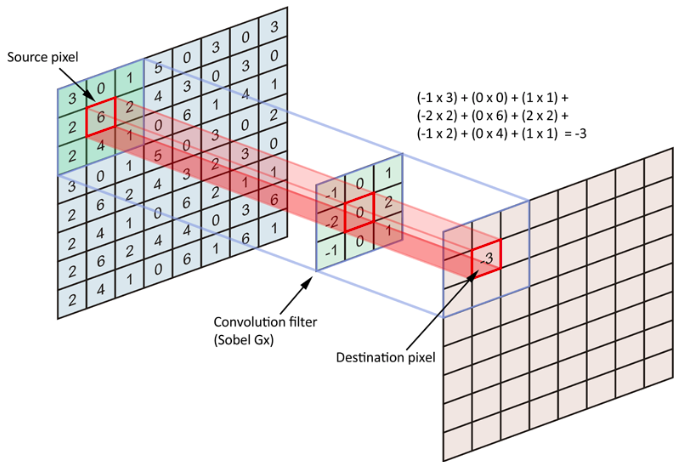

<span style = 'font-size:80%'> image source: https://www.freecodecamp.org/news/an-intuitive-guide-to-convolutional-neural-networks-260c2de0a050/</a>

## Feature maps are created by sliding a filter over the image

In a convolutional layer, the filter (in green in the image below) is slid over the image to yield a new set of outputs which is known as a *feature map* (in red). The filter slides left to right one pixel at a time. When the filter reaches the end of a row, it moves to the beginning of the next row. If the original image is $n$ by $n$, the *feature map* will be $n-2$ by $n-2$ for a 3x3 filter. In the example below, the image is 5x5 and the feature map is 3x3.
<img src="convolve.gif" width="500">

<span style = 'font-size:80%'> image source: https://www.freecodecamp.org/news/an-intuitive-guide-to-convolutional-neural-networks-260c2de0a050/</a>

### Examples of filters

In a *CNN*, the values of the *filter* are weights that are learned during the training process. The values of these weights (i.e., the filter) will determine the features of the image that the neural network learns. For example, in the code below we have three filters:

In [ ]:
import numpy as np


filter1 = np.array( [ [1/9,1/9,1/9],
                     [1/9,1/9,1/9],
                     [1/9,1/9,1/9] 
                   ])

filter2 = np.array( [ [-1, -1, -1],
                      [ 2,  2,  2],
                      [-1, -1, -1] 
                   ])


filter3 = np.array( [ [-1, 2, -1],
                      [-1, 2, -1],
                      [-1, 2, -1] 
                    ])


print('Filter #1 will blur the image (it averages over neighboring pixels) ')
print(filter1.round(2))
print()

print('Filter #2 will detect horizontal edges:')
print(filter2)
print()

print('Filter #3 will detect vertical edges:')
print(filter3)

The *convolve* function below is used to convolve an image _x_ by a filter (*kernel*).

In [ ]:
def convolve (x, kernel) :
    nrow, ncol = x.shape
    convolution = []
    for i in range(nrow-2) :
        for j in range(ncol-2) :
            x_input = x[i:i+3,j:j+3]
            convolution.append (   np.dot(kernel.flatten(), x_input.flatten())   )

    convolution = np.array(convolution).reshape(nrow-2,ncol-2)
    return convolution

Let's view the feature maps created by the filters above that blur the image and detect edges.

In [ ]:
figure, axes = plt.subplots(1,4, figsize = (15,6))
for ax in axes.ravel() :
    ax.axis('off')
    
# plot original image
axes[0].imshow(x4, cmap = plt.cm.gray_r)
axes[0].set_title('Original image')

# plot convolutions
feature_map1 = convolve(x4, filter1)
axes[1].imshow(feature_map1, cmap = plt.cm.gray_r)
axes[1].set_title('Feature map for blurred image')

feature_map2 = convolve(x4, filter2)
axes[2].imshow(feature_map2, cmap = plt.cm.gray_r)
axes[2].set_title('Feature map detecting\nhorizontal edges')

feature_map3 = convolve(x4, filter3)
axes[3].imshow(feature_map3, cmap = plt.cm.gray_r)
axes[3].set_title('Feature map detecting\nvertical edges')

None


## Max Pooling

Convolutional layers are typically followed up with *pooling layers* in order to reduce the number of features (which makes training accurate and more efficient). A *max pooling* layer looks at a small region (typicall 2x2) and returns the maximum value. The pooling regions do not overlap, so that a 2x2 pool will cut the number of features in half.

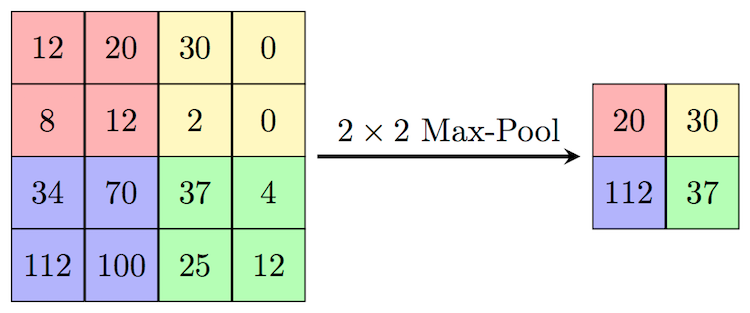

<span style = 'font-size:80%'> image from: https://computersciencewiki.org/images/8/8a/MaxpoolSample2.png </span>

We visualize max pooling by running the code below.

In [ ]:
# function to carry out max pooling using a pool size of 2 x 2
def max_pooling (x) :

    ncol, nrow = x.shape
    pool = []
    for i in range(0,nrow,2) :
        for j in range(0,ncol,2) :
            x_input = x[i:i+2,j:j+2]
            pool.append(x_input.max())
                                        
    pool = np.array(pool).reshape(ncol//2,nrow//2)
    return pool

In [ ]:
x4_pooled = max_pooling(x4)
feature_map1_pooled = max_pooling(feature_map1)
feature_map2_pooled = max_pooling(feature_map2)
feature_map3_pooled = max_pooling(feature_map3)

figure, axes = plt.subplots(1,4, figsize = (15,6))
for ax in axes :
    ax.axis('off')

axes[0].imshow(x4_pooled, cmap = plt.cm.gray_r)
axes[0].set_title('Original image')

axes[1].imshow(feature_map1_pooled, cmap = plt.cm.gray_r)
axes[1].set_title('Filter blurred image')

axes[2].imshow(feature_map2_pooled, cmap = plt.cm.gray_r)
axes[2].set_title('Filter for horizontal edge detection')

axes[3].imshow(feature_map3_pooled, cmap = plt.cm.gray_r)
axes[3].set_title('Filter for vertical edge detection')
None

## Let's build and train the CNN

### Reshape and scale the data

The input matrix to a CNN must be 4-dimensional. The dimensions, in order, correspond to 
1. the number of samples (number of images)
1. the number of rows for each image
1. the number of columns for each image
1. the number of *channels* or the *depth* of each image. A color image will have 3 channels - one for red, one for blue, and one for green.

In our case, we need to reshape the data to specify explicitly that the number of channels is 1.

In [ ]:
X_train = X_train.reshape(60000, 28, 28, 1)
X_test = X_test.reshape(10000, 28, 28, 1)

We next scale the data so that each pixel is between 0 and 1

In [ ]:
maximum = X_train.max()
minimum = X_train.min()

X_train_scaled = (X_train - minimum) / (maximum - minimum)
X_test_scaled = (X_test - minimum) / (maximum - minimum)

### Build the model

We build the model by first creating a Sequential model, and then adding the layers. The first layer for a *CNN* is a convolutional layer where each node is a filter that outputs a feature map. When adding this layer, we specify the number of filters (number of nodes in the layer), the kernel size, the activation function, and optionally, the input shape. We follow this with a pooling layer, then a dense layer, followed by the densely connected output layer.

In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Flatten, Dense, Conv2D, MaxPooling2D

cnn = Sequential()
cnn.add( Conv2D(filters = 60, kernel_size = (3,3), activation = 'relu', input_shape = (28,28, 1))  )
cnn.add(MaxPooling2D(pool_size = (2,2)))
cnn.add(Flatten())
cnn.add(Dense(100, activation = 'relu'))
cnn.add(Dense(10, activation = 'softmax'))
cnn.summary()

### Compile the model

In [ ]:
cnn.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['acc'])

### Train the model

Training is carried out as before, but will take considerably longer because there are over 1 million parameters to learn! Note that the *scaled* data should be used for training; otherwise, learning is not successful.

The code below can be used to fit the *cnn* to our MNIST data. This code includes two new parameters:
- *batch_size* is the number of samples considered simultaneously when updating parameters. Rather than updating weights after looking at each sample individually, weights are updated after evaluating all samples in the batch. Higher batch sizes result in faster training but often produce less accurate results.
- *validation_split* specifies the proportion of samples to set aside for validation. These samples always come from the end of the training data, so training data should be in random order (which is true in our case).

But rather than running the code below, we will load in a model that has been trained previously using the below command.

In [ ]:
history = cnn.fit(X_train_scaled, y_train, epochs=5, batch_size=64, validation_split = .1)

#### Saving and loading a model
After a model has been trained, the entire model can be *saved* using the code
```python
cnn.save('file.h5')
```

You can load a saved model by using the code below. For comparison we load two models, one that was trained using the *scaled* inputs and one trained using the original (unscaled) data.

In [ ]:
from tensorflow.keras.models import load_model
cnn = load_model('cnn_mnist_trained.h5')
cnn_with_unscaled = load_model('cnn_mnist_trained_unscaled.h5')

## Evaluate the results

We can see that accuracy is extremely low when the data is not scaled!

In [ ]:
loss1, acc1 = cnn.evaluate(X_test_scaled, y_test)
loss2, acc2 = cnn_with_unscaled.evaluate(X_test, y_test)

print()
print('cnn with scaled data has an accuracy of: ', acc1)
print('cnn with unscaled data has an accuracy of: ', acc2)



## What is the neural network doing

In general, convolutional layers allow a neural network to learn about structures (feature maps) such as edges. Additional layers look at combinations of structures (feature maps) and can learn more advanced structures (such as the shape of an eye). Ultimately, a particular image has a set of features that activate neurons that lead to a specific classification. 

Let's look at all of the weights from our *cnn*. What do the weights in the first layer represent?

In [ ]:
# get the weights; this includes both the weights and the biases
weights = cnn.get_weights()

print('weights is a list of length: ', len(weights))
print('the first set of weights has shape: ', weights[0].shape)

The first set of weights correspond to each of the sixty 3x3 filters used in the convolution layer. Each filter produces a feature map, so each image is transformed into 60 different feature maps. Let's visualize some of these feature maps below. We first set the image that we want to look at. Then we iterate over the first 9 filters and display the first 9 feature maps.

In [ ]:
# set the image_index for the image to display
image_index = 0

In [ ]:
# extract the image, which has shape (28,28,1). This must be reshaped to (28,28) for plotting
ximage = X_test_scaled[image_index].reshape(28,28)

# extract the filters from the convolutional layer
filters = weights[0]

# iterate through the first 9 filters
feature_maps = [ximage]
for i in range(9) :
    
    # extract the filter
    a_filter = filters[:,:,:,i].reshape(3,3)
    
    # convolve the image to create the feature map
    feature_maps.append( convolve(ximage, a_filter) )


# draw the original image and the feature maps
titles = ['feature map #' + str(i) for i in range(1,10)]
titles = ['original'] + titles
figure, axes = plt.subplots(2,5, figsize = (15,6))

for ax,image, title in zip(axes.ravel(), feature_maps, titles) :
    ax.axis('off')
    ax.imshow(image, cmap = plt.cm.gray_r)
    ax.set_title(title)